# Predicting Stock Prices with Linear Regression

To answer the question if we can accurately predict stock prices over time, I'm going to use Stock Price history data from the Quadl API and apply a regression analysis method.

## Check out the Data

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import yfinance

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

### Get the Data

In [2]:
# Set start and end date for stock prices
start_date = '2009-01-01'
end_date = datetime.date.today()
# Load data from yfinance
data = yfinance.download('QQQ', start=start_date, end=end_date)
# Save data to CSV file
data.to_csv('data/qqq_stock.csv')

[*********************100%***********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,29.750000,31.129999,29.690001,31.030001,27.635725,107891500
2009-01-05,30.830000,31.330000,30.590000,31.020000,27.626810,91751900
2009-01-06,31.250000,31.629999,31.110001,31.330000,27.902905,136791700
2009-01-07,30.730000,30.900000,30.190001,30.440001,27.110258,133879800
2009-01-08,30.379999,30.799999,30.080000,30.760000,27.395250,131926600


In [4]:
# Check data types in columns
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3040 entries, 2009-01-02 to 2021-01-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3040 non-null   float64
 1   High       3040 non-null   float64
 2   Low        3040 non-null   float64
 3   Close      3040 non-null   float64
 4   Adj Close  3040 non-null   float64
 5   Volume     3040 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 166.2 KB


In [5]:
# Get descriptive statistics summary of data set 
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3040.000000,3040.000000,3040.000000,3040.000000,3040.000000,3.040000e+03
mean,113.102161,113.846842,112.276740,113.128852,109.047063,4.984554e+07
std,64.886263,65.376762,64.305103,64.892827,66.172389,3.592978e+07
min,26.090000,26.809999,25.629999,25.740000,22.924377,7.079300e+06
25%,59.035001,59.317500,58.770000,59.174999,53.572860,2.586548e+07
50%,102.494999,103.105000,101.349998,102.190002,97.392639,3.783835e+07
75%,157.965004,159.417500,156.269997,157.575001,154.112507,6.155445e+07
max,328.910004,330.320007,327.220001,328.589996,328.589996,2.882004e+08


In [6]:
# Display features in data set
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

### Select Subset with relevant features

We use the daily closing price **Adj Close** as the value to predict, so we can discard the other features.  

* 'Adj Close' column has numerical data type
* The 'Date' is the index column and contains datetime values

In [7]:
# Create a new DataFrame with only closing price and date
df = pd.DataFrame(data, columns=['Adj Close'])
df['cum_log_rtns'] = np.cumsum(np.log(df['Adj Close']/df['Adj Close'].shift(1)))

# Reset index column so that we have integers to represent time for later analysis
df = df.reset_index()

In [8]:
df.head()

,Date,Adj Close,cum_log_rtns
0,2009-01-02,27.635725,NaN
1,2009-01-05,27.626810,-0.000323
2,2009-01-06,27.902905,0.009621
3,2009-01-07,27.110258,-0.019197
4,2009-01-08,27.395250,-0.008740


In [9]:
# Check data types in columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3040 non-null   datetime64[ns]
 1   Adj Close     3040 non-null   float64       
 2   cum_log_rtns  3039 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 71.4 KB


In [10]:
# Check for missing values in the columns
df = df.dropna()
df.isna().values.any()

False

## Explore the Data

When we take a look at the price movement over time by simply plotting the *Adj Close* vs *Time*, we can already see, that the price continously increases over time and we can also estimate that trend could be linear.

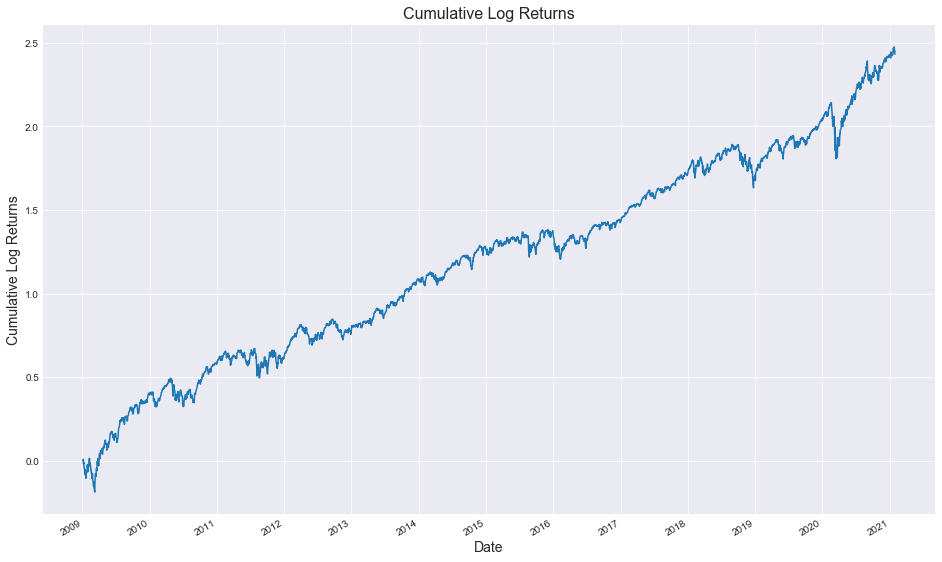

In [11]:
# Import matplotlib package for date plots
import matplotlib.dates as mdates

years = mdates.YearLocator() # Get every year
yearsFmt = mdates.DateFormatter('%Y') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['cum_log_rtns'])

# Format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

# Set figure title
plt.title('Cumulative Log Returns', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Cumulative Log Returns', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

## Linear Regression
 
Our data contains only one **independent variable ($X$)** which represents the *date* and the **dependent variable ($Y$)** we are trying to predict is the *Stock Price*. To fit a line to the data points, which then represents an estimated relationship between $X$ and $Y$, we can use a **Simple Linear Regression**.

The best fit line can be described with  
$$
Y = \beta_0 + \beta_1 X
$$

where  
* $Y$ is the predicted value of the dependent variable
* $\beta_0$ is the y-intercept
* $\beta_1$ is the slope
* $X$ is the value of the independent variable

The goal is to find such coefficients $\beta_0$ and $\beta_1$ that the **Sum of Squared Errors**, which represents the difference between each point in the dataset with it’s corresponding predicted value outputted by the model, is minimal.

### Training a Linear Regression Model

### Train Test Split

In [12]:
# Import package for splitting data set
from sklearn.model_selection import train_test_split

In [13]:
# Split data into train and test set: 80% / 20%
train, test = train_test_split(df, test_size=0.20)

### Create and Train the Model

In [14]:
# Import package for linear model
from sklearn.linear_model import LinearRegression

In [15]:
# Reshape index column to 2D array for .fit() method
X_train = np.array(train.index).reshape(-1, 1)
y_train = train['cum_log_rtns']

In [16]:
X_train

array([[1317],
       [ 702],
       [1870],
       ...,
       [2000],
       [2503],
       [1208]])

In [17]:
y_train

1317    1.086071
702     0.648850
1870    1.345242
2055    1.524869
2510    1.658452
          ...   
2270    1.749640
739     0.629763
2000    1.425353
2503    1.770398
1208    1.020726
Name: cum_log_rtns, Length: 2431, dtype: float64

In [18]:
# Create LinearRegression Object
model = LinearRegression()
# Fit linear model using the train data set
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Model Evaluation

In [19]:
# The coefficient
print('Slope: ', np.squeeze(model.coef_))
# The Intercept
print('Intercept: ', model.intercept_)

Slope:  0.0006875312914840961
Intercept:  0.14740242343232834


###### Interpreting the coefficients:

* The **slope** coefficient tells us that with a 1 unit increase in **date** the **closing price** increases by 0.0868 $
* The **intercept** coefficient is the price at wich the **closing price** measurement started, the stock price value at date zero

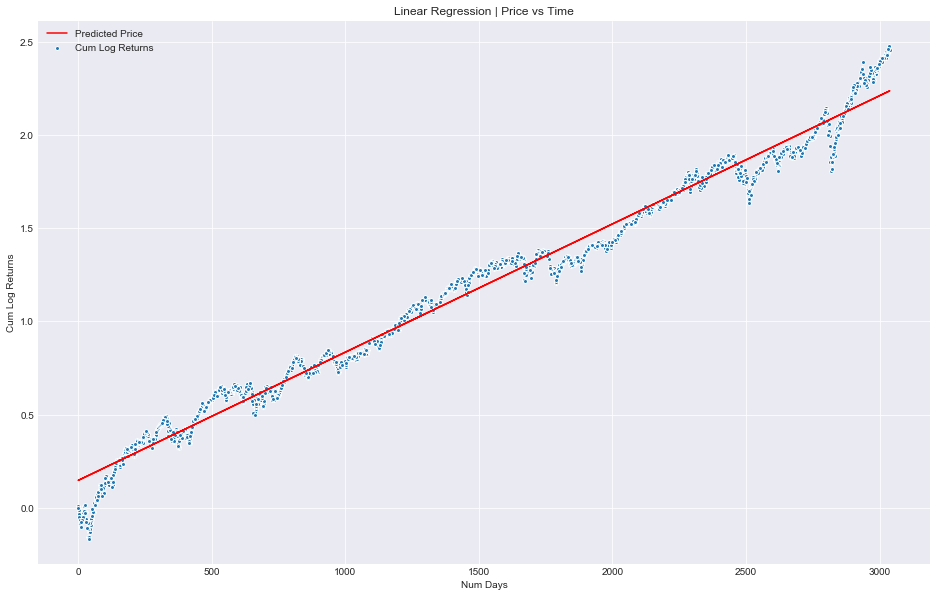

In [20]:
# Train set graph
plt.figure(1, figsize=(16,10))
plt.title('Linear Regression | Price vs Time')
plt.scatter(X_train, y_train, edgecolor='w', label='Cum Log Returns')
plt.plot(X_train, model.predict(X_train), color='r', label='Predicted Price')
plt.xlabel('Num Days')
plt.ylabel('Cum Log Returns')
plt.legend()
plt.show()

### Prediction from our Model

In [21]:
# Create test arrays
X_test = np.array(test.index).reshape(-1, 1)
y_test = test['cum_log_rtns']

In [22]:
# Generate array with predicted values
y_pred = model.predict(X_test)

## Regression Evaluation

Let's have a look at how the predicted values compare with the actual value on random sample from our data set.

In [23]:
# Get number of rows in data set for random sample
df.shape

(3039, 3)

In [24]:
# Generate 25 random numbers
randints = np.random.randint(3031, size=25)

# Select row numbers == random numbers
df_sample = df[df.index.isin(randints)]

In [25]:
df_sample['Predicted'] = model.predict(np.array(df_sample.index).reshape(-1, 1))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
df_sample.head()

,Date,Adj Close,cum_log_rtns,Predicted
117,2009-06-22,31.332861,0.125558,0.227844
271,2010-02-01,38.741039,0.337790,0.333723
322,2010-04-15,44.941292,0.486248,0.368787
532,2011-02-11,52.821362,0.647806,0.513169
603,2011-05-25,51.402428,0.620576,0.561984


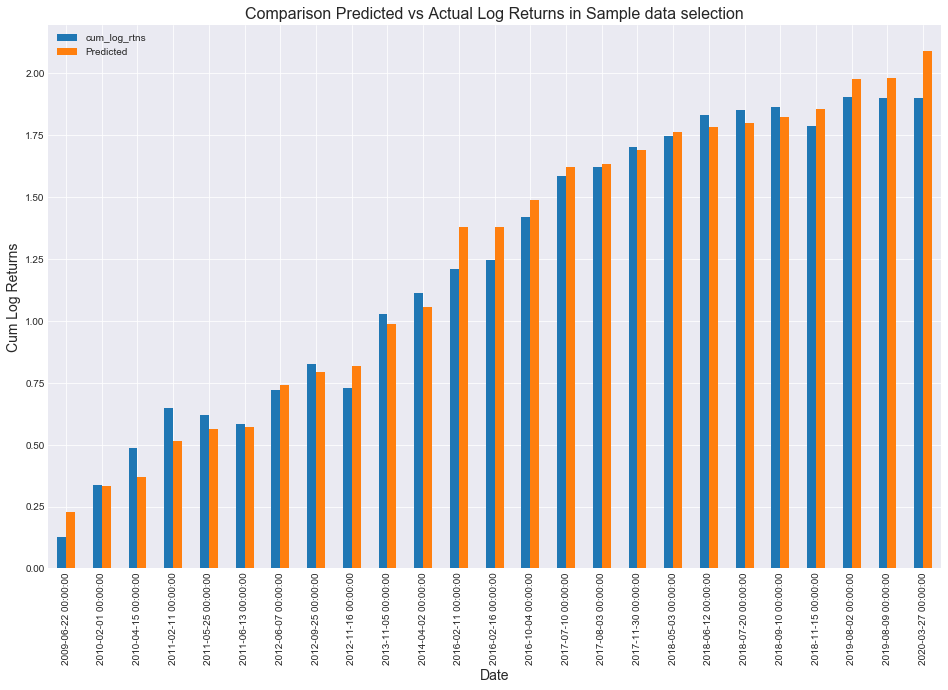

In [27]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
df_sample.plot(x='Date', y=['cum_log_rtns', 'Predicted'], kind='bar', ax=ax)

# Set figure title
plt.title('Comparison Predicted vs Actual Log Returns in Sample data selection', fontsize=16)

# 

# Set x label
plt.xlabel('Date', fontsize=14)

# Set y label
plt.ylabel('Cum Log Returns', fontsize=14)

# Show plot
plt.show()

We can see some larger variations between predicted and actual values in the random sample.  
Let's see how the model performed over the whole test data set. 

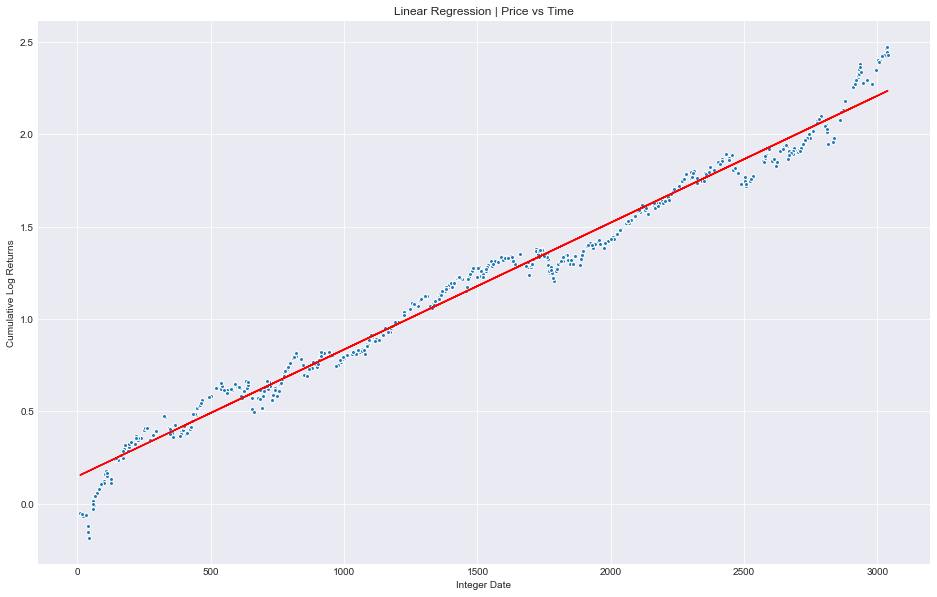

In [28]:
# Plot fitted line, y test
plt.figure(1, figsize=(16,10))
plt.title('Linear Regression | Price vs Time')
plt.plot(X_test, model.predict(X_test), color='r', label='Predicted Returns')
plt.scatter(X_test, y_test, edgecolor='w', label='Actual Returns')

plt.xlabel('Integer Date')
plt.ylabel('Cumulative Log Returns')

plt.show()

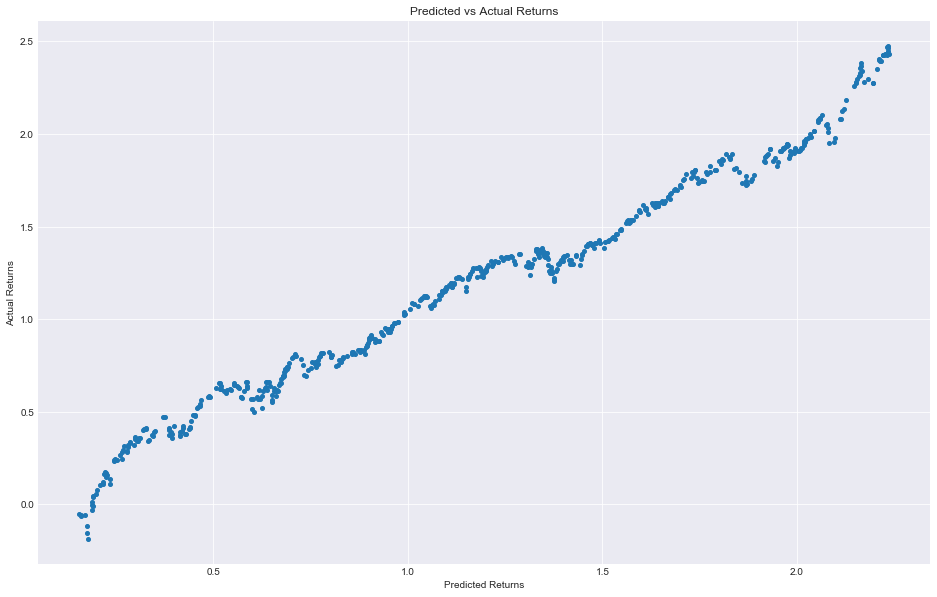

In [29]:
# Plot predicted vs actual prices
plt.scatter(y_pred, y_test)

plt.xlabel('Predicted Returns')
plt.ylabel('Actual Returns')

plt.title('Predicted vs Actual Returns')

plt.show()

The data points are mostly close to a diagonal, which indicates, that the predicted values are close to the actual value and the model's performance is largerly quite good.  

#### Residual Histogram

The residuals are nearly normally distributed around zero, with a slight skewedness to the right. 

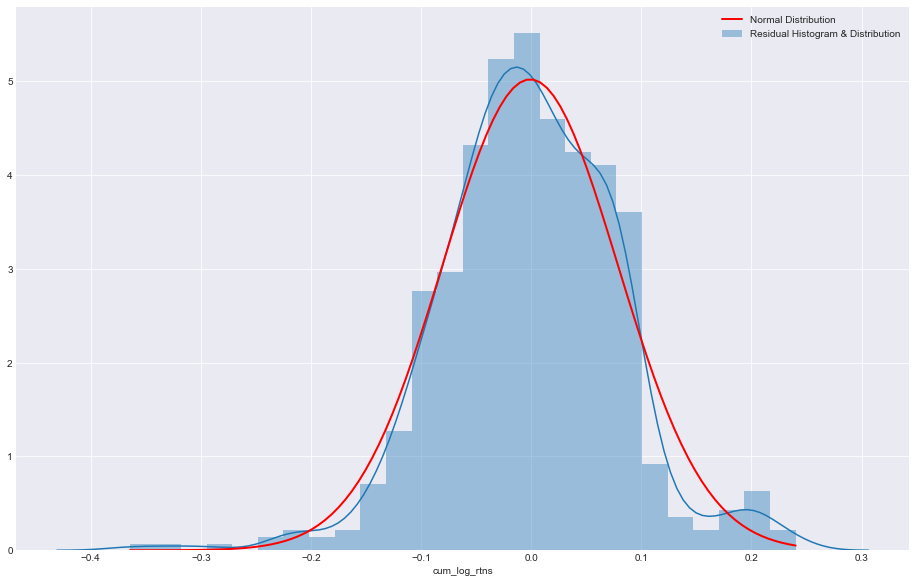

In [30]:
# Import norm package to plot normal distribution
from scipy.stats import norm

# Fit a normal distribution to the data:
mu, std = norm.fit(y_test - y_pred)

ax = sns.distplot((y_test - y_pred), label='Residual Histogram & Distribution')

# Calculate the pdf over a range of values         
x = np.linspace(min(y_test - y_pred), max(y_test - y_pred), 100)
p = norm.pdf(x, mu, std)

# And plot on the same axes that seaborn put the histogram
ax.plot(x, p, 'r', lw=2, label='Normal Distribution') 

plt.legend()
plt.show()

In [31]:
# Add new column for predictions to df
df['Prediction'] = model.predict(np.array(df.index).reshape(-1, 1))

In [32]:
df.head()

,Date,Adj Close,cum_log_rtns,Prediction
1,2009-01-05,27.626810,-0.000323,0.148090
2,2009-01-06,27.902905,0.009621,0.148777
3,2009-01-07,27.110258,-0.019197,0.149465
4,2009-01-08,27.395250,-0.008740,0.150153
5,2009-01-09,26.780731,-0.031427,0.150840


### Error Evaluation Metrics

**Mean Absolute Error (MAE)** is the mean of the absolute value of the errors:
$$
\frac{1}{N} \sum_{i = 1}^{N} |y_i - \hat{y}_i|
$$

**Mean Squared Error (MSE)** is the mean of the squared errors:
$$
\frac{1}{N} \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2
$$

**Root Mean Squared Error (RMSE)** is the square root of the mean of the squared errors:
$$
\sqrt{\frac{1}{N} \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2}
$$

All of these are **cost functions** we want to minimize.

In [33]:
# Import metrics package from sklearn for statistical analysis
from sklearn import metrics

In [34]:
# Statistical summary of test data
df['cum_log_rtns'].describe()

count    3039.000000
mean        1.192268
std         0.609828
min        -0.186908
25%         0.662222
50%         1.259780
75%         1.718811
max         2.475701
Name: cum_log_rtns, dtype: float64

In [35]:
# Calculate and print values of MAE, MSE, RMSE
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.06115260042826858
Mean Squared Error: 0.006322470849485555
Root Mean Squared Error: 0.07951396638003637


### Accuracy Evaluation Metrics

To see how accurate our model is, we can calculate the **Coefficient of determination**, which describes the ratio between the total error and the error, that is explained by our model. It's value is between 0 and 1, with 1 meaning 100% of the error is acoounted for by the model. 

**Coefficient of determination**
$$
R^2 = 1 - \frac{RSS}{TSS}
$$

with  

**Residual Sum of Squares (RSS)**
$$
RSS = \sum_{i = 1}^{N} \epsilon_i^2 = \sum_{i = 1}^{N} (y_i - \hat{y}_i)^2
$$

**Total Sum of Squares (TSS)**
$$
TSS = \sum_{i = 1}^{N} (y_i - \bar{y}_i)^2
$$


In [36]:
print('R2: ', metrics.r2_score(y_test, y_pred))

R2:  0.9823269080154287


In [37]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred)

0.9823292160843141

The value of $R^2$ shows that are model accounts for nearly 87% of the differences between the actual stock prices and the predicted prices. 